# Song popularity dataset
Predicting the popularity of a song

### Importing library's

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.constraints import MinMaxNorm
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

%matplotlib widget

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## EDA/Pre-Processing
Exploratory data analysis

In [104]:
df = pd.read_csv("../archive/song_data.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [105]:
df.shape

(18835, 15)

Delete duplicates, based on song name

In [106]:
df.drop_duplicates(subset='song_name', keep='first', inplace=True)
df.shape

(13070, 15)

Drop song name feature

In [107]:
df = df.drop('song_name', axis=1)

Look at the composition of the dataset

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13070 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   13070 non-null  int64  
 1   song_duration_ms  13070 non-null  int64  
 2   acousticness      13070 non-null  float64
 3   danceability      13070 non-null  float64
 4   energy            13070 non-null  float64
 5   instrumentalness  13070 non-null  float64
 6   key               13070 non-null  int64  
 7   liveness          13070 non-null  float64
 8   loudness          13070 non-null  float64
 9   audio_mode        13070 non-null  int64  
 10  speechiness       13070 non-null  float64
 11  tempo             13070 non-null  float64
 12  time_signature    13070 non-null  int64  
 13  audio_valence     13070 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 1.5 MB


Check for null values

In [109]:
df.isnull().values.any()

False

In [110]:
# Optional Visualisation
# sns.pairplot(df)

### Correlation matrix

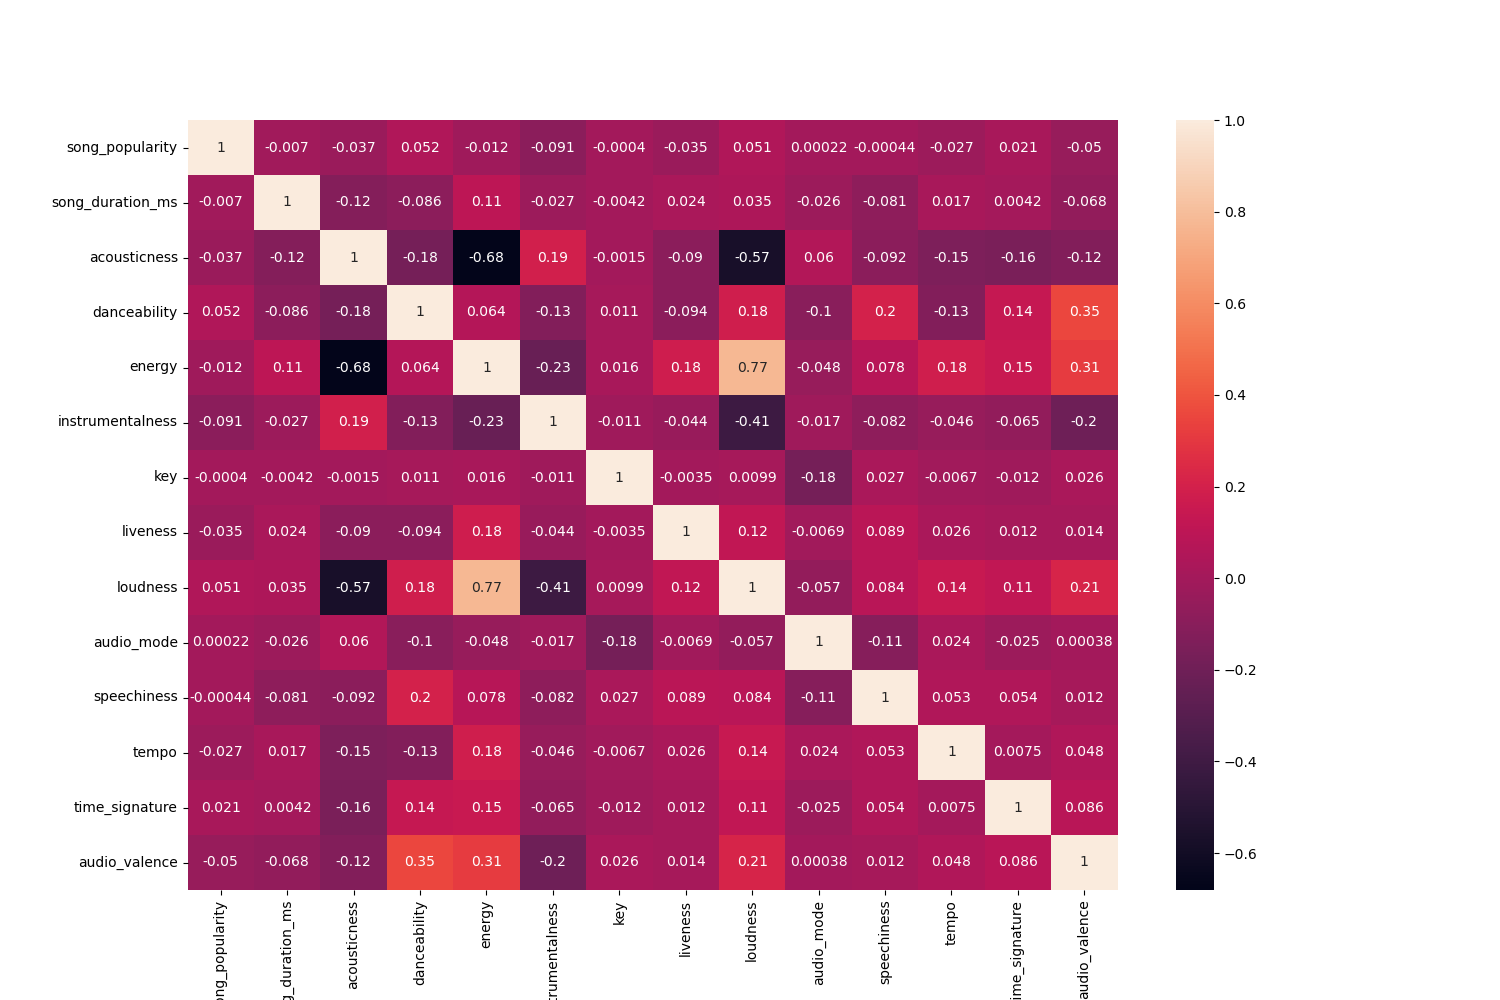

In [111]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot= True,)
plt.show()

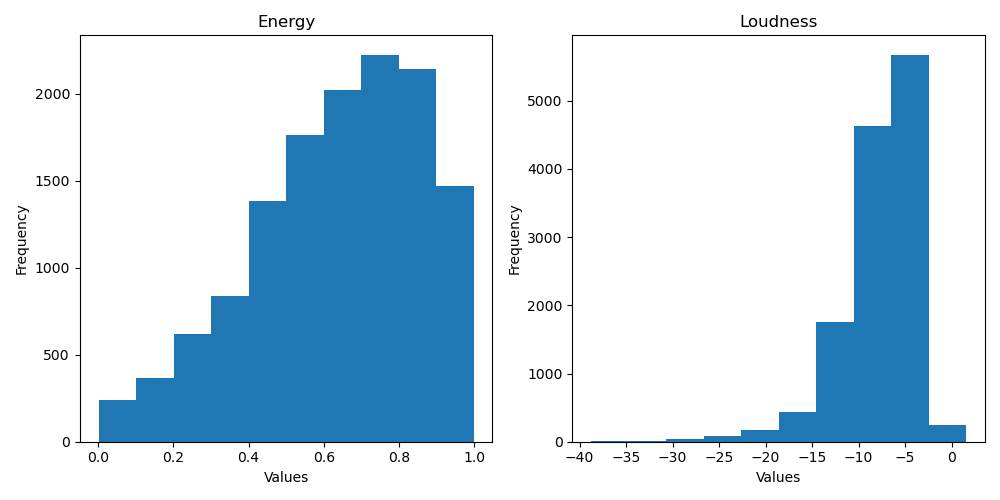

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(df['energy'])
axs[0].set_title('Energy')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')

axs[1].hist(df['loudness'])
axs[1].set_title('Loudness')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

Loudness and Energy is strong correlated, so we can drop one of them, because they give the same info to the model

In [113]:
df = df.drop('loudness', axis=1)

In [114]:
df.shape

(13070, 13)

In [115]:
X, y = df.drop(['song_popularity'],axis=1).to_numpy(), df['song_popularity'].to_numpy()

In [116]:
X.shape

(13070, 12)

### Splitting: 60% training, 40% test and Scaling: StandardScaler

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.4, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (7842, 12) y_train.shape (7842,)
X_test.shape (5228, 12) y_test.shape (5228,)


In [118]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

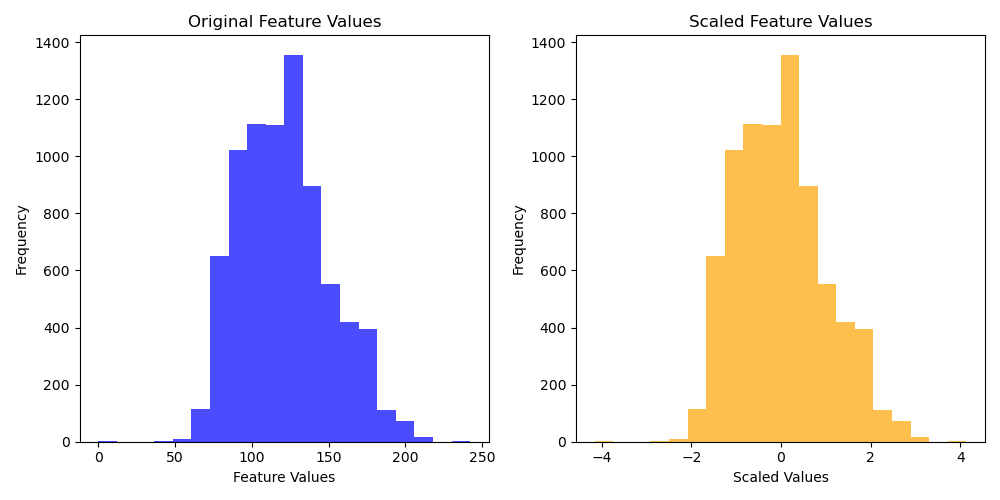

In [119]:
nb = 9
original_feature_values = X_train[:, nb] 

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(original_feature_values, bins=20, color='blue', alpha=0.7)
plt.title('Original Feature Values')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(X_train_scaled[:, nb], bins=20, color='orange', alpha=0.7)
plt.title('Scaled Feature Values')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Making the model

Using the tuned hyperparameters

In [120]:
output_constraint = MinMaxNorm(min_value=0, max_value=100, rate=1.0, axis=0)
model_regression_tuned = Sequential(
    [

        Dense(400, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization obtained from tuning
        Dense(200, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization obtained from tuning
        Dense(100, activation='relu', name="L4", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization obtained from tuning
        Dense(50, activation='relu', name="L3", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization obtained from tuning
        Dense(1, activation='linear', kernel_constraint=output_constraint, name="Output"),  # Linear activation for regression

    ], name="my_regression_model_tuned"
)

model_regression_tuned.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Alpha obtained from tuning
     )

In [121]:
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_scaled):
    train_index = train_index[train_index < len(X_train_scaled)]
    val_index = val_index[val_index < len(X_train_scaled)]
    X_train_val, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_val, y_val = y_train[train_index], y_train[val_index]

    model_regression_tuned.fit(X_train_val, y_train_val, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
197/197 [==============================] - 1s 2ms/step - loss: 1978.6848 - val_loss: 623.4338
Epoch 2/200
197/197 [==============================] - 0s 2ms/step - loss: 542.6903 - val_loss: 508.7173
Epoch 3/200
197/197 [==============================] - 0s 2ms/step - loss: 502.4655 - val_loss: 491.6027
Epoch 4/200
197/197 [==============================] - 0s 2ms/step - loss: 489.7025 - val_loss: 479.9058
Epoch 5/200
197/197 [==============================] - 0s 2ms/step - loss: 481.0738 - val_loss: 476.4283
Epoch 6/200
197/197 [==============================] - 0s 2ms/step - loss: 474.2188 - val_loss: 465.9057
Epoch 7/200
197/197 [==============================] - 0s 2ms/step - loss: 467.9237 - val_loss: 459.6051
Epoch 8/200
197/197 [==============================] - 0s 2ms/step - loss: 462.2556 - val_loss: 454.9117
Epoch 9/200
197/197 [==============================] - 0s 2ms/step - loss: 457.4152 - val_loss: 451.2912
Epoch 10/200
197/197 [==============================] 

## Evaluation

In [122]:
number_of_tests = X_test.shape[0]-1
sum_difference = 0
predictions = []
actual = y_test[:number_of_tests]
accuracy_variance = 0

for i in range(number_of_tests):
    predictions.append(model_regression_tuned.predict(X_test_scaled[i].reshape(1,12))[0][0])
    # print(f"{predictions[i]} -> {y_test[i]}")
    sum_difference += abs(predictions[i] - y_test[i])
    accuracy_variance += (np.abs(predictions[i]-y_test[i]) <= 15)
    
mape = 100 * (sum_difference / (np.sum(y_test[:number_of_tests])))
accuracy = abs(100 - np.mean(mape))

print(f"Mean Absolute Error: {round((sum_difference/number_of_tests),2)}")
print("Accuracy : ", round(accuracy, 2), '%')
print(f"Accuracy of difference between +-15: {100*accuracy_variance/number_of_tests}")

1/1 [==============================] - 0s 19ms/step
Mean Absolute Error: 20.91
Accuracy :  57.04 %
Accuracy of difference between +-15: 45.131050315668645


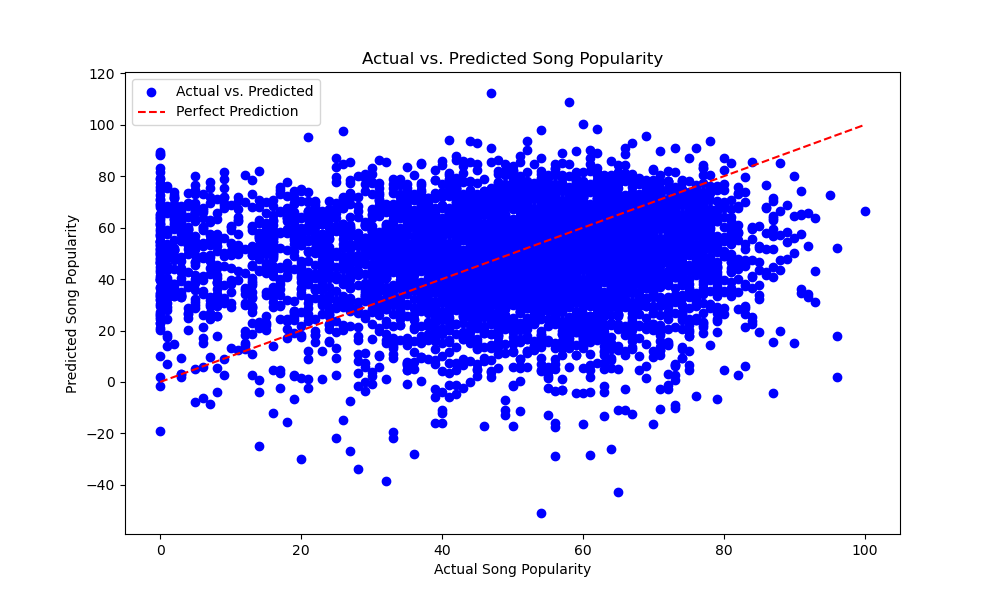

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(actual, np.clip(predictions, 0, 100), color='blue', label='Actual vs. Predicted')
plt.plot([0, 100], [0, 100], linestyle='--', color='red', label='Perfect Prediction')

plt.xlabel('Actual Song Popularity')
plt.ylabel('Predicted Song Popularity')
plt.title('Actual vs. Predicted Song Popularity')

plt.legend()

plt.show()

Correlation Coefficient

In [124]:
correlation_coefficient, _ = pearsonr(predictions, actual)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.07686378153285035
